# 02c Merge datasets across regions and domains 

---

In [1]:
#|default_exp core.02c_merge_data

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02c_GP_doctors_per_LAD.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

--- 

In [6]:
# Load the datasets with Local Authority District demographic info 
df_lad_age_21 = pd.read_csv(const.output_path+'/LAD_age_2021.csv')
df_lad_ethn_21 = pd.read_csv(const.output_path+'/LAD_ethnicity_percent_2021.csv')
df_lad_educ_21 = pd.read_csv(const.output_path+'/LAD_education_2021.csv')

# And the ADI health dataset
df_ADI_health_21 = pd.read_csv(const.data_path+'/ADI_data/ADI_health_2021.csv')

# and the count of GP doctors per LAD
df_GP_count = pd.read_csv(const.pre_output_path+'/GP_contribution_LAD.csv')

In [7]:
print(f'Number of LADs in the ADI dataset: {len(df_ADI_health_21)}. Number of LADs in the demographic dataset: {len(df_lad_age_21)}.')

Number of LADs in the ADI dataset: 309. Number of LADs in the demographic dataset: 331.


In [8]:
# Fix the mismatch in LADs resulting from the inclusion of Welsh LADs - poor old Wales :(
wales_LAD = list(df_lad_age_21[~df_lad_age_21['LAD_name'].isin(df_ADI_health_21['area_name'])]['LAD_name'])

# Drop all the LADs in Wales from datasets 
df_lad_age_21.drop(df_lad_age_21[df_lad_age_21['LAD_name'].isin(wales_LAD)].index, inplace=True)
df_lad_educ_21.drop(df_lad_educ_21[df_lad_educ_21['Area name'].isin(wales_LAD)].index, inplace=True)
df_lad_ethn_21.drop(df_lad_ethn_21[df_lad_ethn_21['Area name'].isin(wales_LAD)].index, inplace=True)

Now a little bit of processing to merge categories and get an informative percent. For covariates I'm looking at:
* percent of the population over 65
* percent of the population with A-level or higher qualifications 
* percent of the population who have white ethnicity 

In [9]:
df_lad_educ_21['ALevel_plus'] = df_lad_educ_21['level 3: a-level']+df_lad_educ_21['level 4: bsc']

Also want to look at the health conditions which might be confounders, specifically:
- Hypertension (HYP)
- Diabetes (DM)
- Stroke + Coronary heart disease + Transient ischaemic attack (STIA)

Could also consider:
- Depression (DEP)
- Parkinsonism - not in the QOF dataset - I suspect this is clustered under dementia 
- Chronic Obstructive Pulmonary disease (COPD)
- asthma (AST)
- Cardiovascular disease (CVD-PP)
- Age-related musculoskeletal disorders - not in the QOF dataset 

The codes for each health domain come from: health_indicator_keys.xlsx available via ADI 

In [10]:
# change some LAD names in the ADI dataset
df_lad_educ_21.replace({'Herefordshire':'Herefordshire, County of', 'Kingston upon Hull':'Kingston upon Hull, City of', 'Bristol':'Bristol, City of'}, inplace=True)
#df_ADI_health_21.replace({'Herefordshire, County of':'Herefordshire', 'Kingston upon Hull, City of':'Kingston upon Hull', 'Bristol, City of':'Bristol'}, inplace=True)
#df_lad_age_21.replace({'Herefordshire, County of':'Herefordshire', 'Kingston upon Hull, City of':'Kingston upon Hull', 'Bristol, City of':'Bristol'}, inplace=True)
#df_lad_ethn_21.replace({'Herefordshire, County of':'Herefordshire', 'Kingston upon Hull, City of':'Kingston upon Hull', 'Bristol, City of':'Bristol'}, inplace=True)

# merge the datasets into one 
df_dem_educ = pd.merge(df_ADI_health_21[['area_code', 'area_name', 'pop', 'DEM_afflicted', 'HYP_afflicted', 'DM_afflicted', 'STIA_afflicted']], df_lad_educ_21[['Area name', 'ALevel_plus']], left_on='area_name', right_on='Area name')
print(len(df_dem_educ))
df_dem_educ_age = pd.merge(df_dem_educ, df_lad_age_21, left_on='area_name', right_on='LAD_name')
print(len(df_dem_educ_age))
df_dem_covar =  pd.merge(df_dem_educ_age, df_lad_ethn_21[["Area name","White: English, Welsh, Scottish, Northern Irish or British\n(percent)"]], left_on='area_name', right_on='Area name')
print(len(df_dem_covar))

# rename long col name
df_dem_covar.rename(axis=1, mapper={'White: English, Welsh, Scottish, Northern Irish or British\n(percent)':'white_pc'}, inplace=True)

# drop some duplicated columns 
df_dem_covar.drop(axis=1, labels=['Area name_x', 'Area name_y', 'LAD_name'], inplace=True)

309
309
309


In [11]:
df_lad_age_21[~df_lad_age_21['LAD_name'].isin(df_dem_educ['area_name'])]

,LAD_name,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65


In [12]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65,white_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826,93.2
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606,63.0
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090,84.2
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648,87.8
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806,93.8


In [13]:
len(df_dem_covar)

309

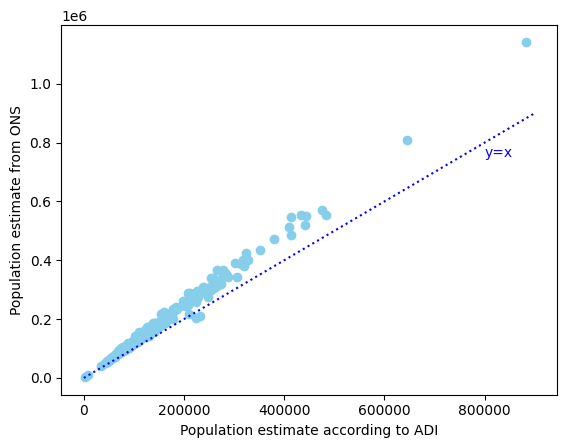

In [14]:
plt.scatter(df_dem_covar['pop'], df_dem_covar['all_age'], color = 'skyblue')
plt.plot(np.arange(900000), np.arange(900000), ':', color='b')
plt.text(800000, 750000, r'y=x', fontsize=10, color='b')
plt.xlabel('Population estimate according to ADI')
plt.ylabel('Population estimate from ONS')
plt.show()

In [15]:
# create dataframe columns with percentages 
df_dem_covar['DEM_afflicted_pc'] = df_dem_covar['DEM_afflicted']/df_dem_covar['pop']
df_dem_covar['ALevel_plus_pc'] =  df_dem_covar['ALevel_plus']/df_dem_covar['pop']
df_dem_covar['over_65_pc'] = df_dem_covar['over_65']/df_dem_covar['pop']
df_dem_covar['female_pc'] = df_dem_covar['Female_all']/df_dem_covar['pop']
df_dem_covar['white_pc'] = df_dem_covar['white_pc']/100

In [16]:
# and columns with disease prevalence for the comorbidities of hypertension (HYP), diabetes (DM) and stroke (STIA)
df_dem_covar['HYP_afflicted_pc'] = df_dem_covar['HYP_afflicted']/df_dem_covar['pop']
df_dem_covar['DM_afflicted_pc'] = df_dem_covar['DM_afflicted']/df_dem_covar['pop']
df_dem_covar['STIA_afflicted_pc'] = df_dem_covar['STIA_afflicted']/df_dem_covar['pop']

In [17]:
# percent over 65 
df_dem_covar['over_65_pc'] = df_dem_covar['over_65']/df_dem_covar['pop']

# percent female 


### Add GP counts for each LAD

In [18]:
df_GP_count.head()

,LAD_name,GP_contribution_to_LAD
0,Adur,41.440908
1,Allerdale,112.253570
2,Amber Valley,146.080012
3,Arun,166.681049
4,Ashfield,113.645554


In [19]:
len(df_GP_count)

309

In [20]:


df_dem_covar = pd.merge(df_dem_covar, df_GP_count, left_on='area_name', right_on='LAD_name')
df_dem_covar['GP_LAD_pc'] = df_dem_covar['GP_contribution_to_LAD']/df_dem_covar['pop']
df_dem_covar.drop(columns='LAD_name', inplace=True)

In [21]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,0.932,0.012269,0.480252,0.342754,0.604124,0.190731,0.061649,0.029487,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,0.630,0.006481,0.720170,0.201778,0.645599,0.103726,0.036506,0.012880,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,0.842,0.009222,0.551399,0.237524,0.626593,0.135847,0.048480,0.019880,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,0.878,0.009969,0.533413,0.239143,0.589346,0.136400,0.055064,0.021488,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,0.938,0.008057,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507,77.360723,0.001138


In [22]:
len(df_dem_covar)

309

In [23]:
# save a .csv of `df_dem_covar`
df_dem_covar.to_csv(const.output_path+'/df_dem_plus.csv', index=False)